#  RNN Text Classification  

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from itertools import product
from sklearn.metrics import f1_score

import pandas as pd, matplotlib.pyplot as plt
import  itertools
import dataset,  keras_model, numpy_rnn

In [14]:
train_ds, val_ds, (vect, x_test, y_test) = dataset.prepare_datasets(seed=42)

for x_batch, y_batch in train_ds.take(1):
    print("Tokenized:", x_batch.numpy()[0])
    print("Label   :",  y_batch.numpy()[0])


Tokenized: [  80 1340   27   38   76   17  223    2 2576 1495    3  602   80  614
  506 1023   92 2428    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Label   : 1


In [ ]:
train_ds, val_ds, (vect, x_test, y_test) = dataset.prepare_datasets(seed=42)

def train_cfg(num_layers, units, bi, seed=42):
    tf.keras.utils.set_random_seed(seed)
    tf.keras.backend.clear_session()

    m = keras_model.build_rnn_model(vocab_size=vect.vocabulary_size(), num_layers=num_layers, units=units, bidirectional=bi)

    h = m.fit(train_ds, validation_data=val_ds, epochs=20,
              callbacks=[
                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_sce", factor=0.5, patience=1),
                  tf.keras.callbacks.EarlyStopping(monitor="val_sce", patience=3, restore_best_weights=True)], verbose=0)

    y_pred = m.predict(vect(x_test), verbose=0).argmax(1)
    f1 = f1_score(y_test, y_pred, average="macro")

    return {
        "layers": num_layers,
        "units": units,
        "bi": bi,
        "f1": f1,
        "loss": h.history["loss"],
        "val_loss": h.history["val_loss"]
    }

In [ ]:
# Pengujian
layers_list = [1, 2, 3]
units_list  = [32, 64, 128]
bi_list     = [False, True]

runs = [train_cfg(L, U, bi) for L, U, bi in itertools.product(layers_list, units_list, bi_list)]
df_results = pd.DataFrame([{k: r[k] for k in ("layers","units","bi","f1")} for r in runs])
print(df_results)

    layers  units     bi        f1
0        1     32  False  0.528148
1        1     32   True  0.625268
2        1     64  False  0.604711
3        1     64   True  0.588726
4        1    128  False  0.424365
5        1    128   True  0.608751
6        2     32  False  0.561134
7        2     32   True  0.560240
8        2     64  False  0.516052
9        2     64   True  0.570563
10       2    128  False  0.437578
11       2    128   True  0.446875
12       3     32  False  0.481256
13       3     32   True  0.502067
14       3     64  False  0.382368
15       3     64   True  0.491549
16       3    128  False  0.332830
17       3    128   True  0.417136


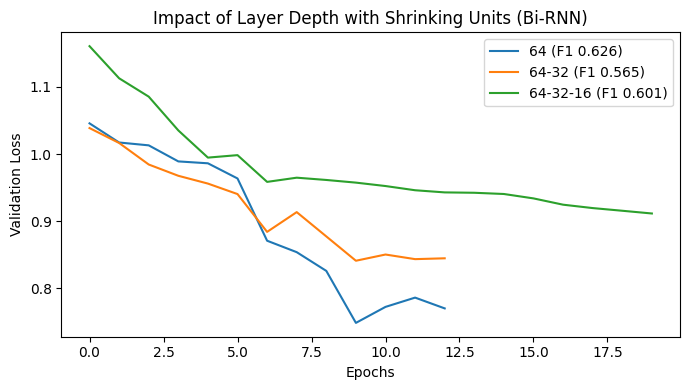

In [ ]:
special_cfgs = [
    (1, [64],          True,  "64"),         
    (2, [64, 32],      True,  "64-32"),      
    (3, [64, 32, 16],  True,  "64-32-16"),    
]

special_runs = []
for L, unit_list, bi, tag in special_cfgs:
    result = train_cfg(L, unit_list, bi)     
    result["tag"] = tag
    special_runs.append(result)

plt.figure(figsize=(7,4))
for r in special_runs:
    plt.plot(r["val_loss"], label=f"{r['tag']} (F1 {r['f1']:.3f})")

plt.title("Impact of Layer Depth with Shrinking Units (Bi-RNN)")
plt.xlabel("Epochs"); plt.ylabel("Validation Loss")
plt.legend(); plt.tight_layout()
plt.savefig("saved/layers_shrink_vs_loss.png")
plt.show()


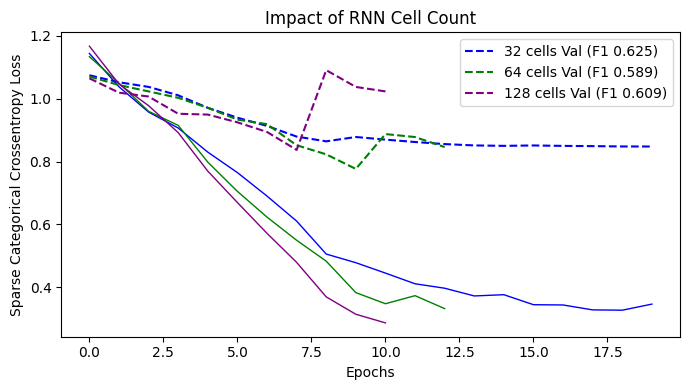

In [18]:
plt.figure(figsize=(7,4))
for r in runs:
    if r["layers"]==1 and r["bi"]:
        color = {32:"blue",64:"green",128:"purple"}[r["units"]]
        plt.plot(r["loss"],      color=color,          linewidth=1)
        plt.plot(r["val_loss"],  color=color, linestyle="--",
                 label=f"{r['units']} cells Val (F1 {r['f1']:.3f})")

plt.title("Impact of RNN Cell Count")
plt.xlabel("Epochs"); plt.ylabel("Sparse Categorical Crossentropy Loss")
plt.legend(); plt.tight_layout()
plt.savefig("saved/units_vs_loss.png")
plt.show()


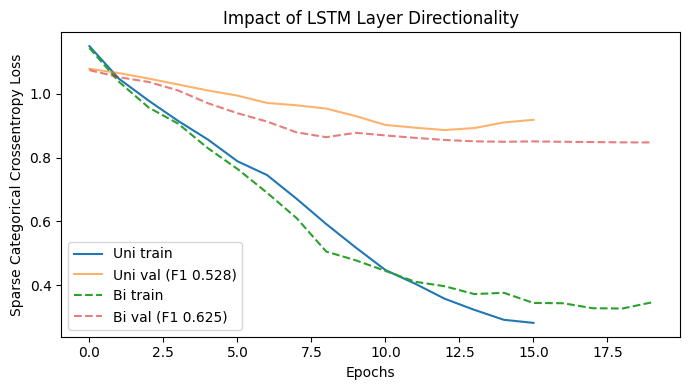

In [19]:
plt.figure(figsize=(7,4))
for r in runs:
    if r["layers"]==1 and r["units"]==32:
        style = "-" if not r["bi"] else "--"
        plt.plot(r["loss"],  label=f"{'Uni' if not r['bi'] else 'Bi'} train",  linestyle=style)
        plt.plot(r["val_loss"], label=f"{'Uni' if not r['bi'] else 'Bi'} val (F1 {r['f1']:.3f})",
                 linestyle=style, alpha=0.6)

plt.title("Impact of LSTM Layer Directionality")
plt.xlabel("Epochs"); plt.ylabel("Sparse Categorical Crossentropy Loss")
plt.legend(); plt.tight_layout()
plt.savefig("saved/dir_vs_loss.png")
plt.show()


In [20]:
import os, shutil, tensorflow as tf, dataset,  keras_model

SAVE_DIR        = "saved"
WEIGHTS_PATH    = os.path.join(SAVE_DIR, "rnn32bi.weights.h5")
VECTORIZER_PATH = os.path.join(SAVE_DIR, "vectorizer.keras")

os.makedirs(SAVE_DIR, exist_ok=True)

train_ds, val_ds, (vect, x_test, y_test) = dataset.prepare_datasets(seed=42)

best_model = keras_model.build_rnn_model(
    vocab_size=vect.vocabulary_size(),
    num_layers=1,
    units=32,
    bidirectional=True,
    dropout=0.3,
    rec_dropout=0.15,     
)

best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_sce", factor=0.5, patience=1, min_lr=1e-5
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_sce", patience=3, restore_best_weights=True
        ),
    ],
    verbose=2,
)


if os.path.exists(WEIGHTS_PATH):
    os.remove(WEIGHTS_PATH)
best_model.save_weights(WEIGHTS_PATH)

if os.path.exists(VECTORIZER_PATH):
    shutil.rmtree(VECTORIZER_PATH) if os.path.isdir(VECTORIZER_PATH) \
        else os.remove(VECTORIZER_PATH)

vect_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    vect
])
vect_model.save(VECTORIZER_PATH)

print("✅  Bobot & vectorizer tersimpan di folder 'saved/'")


Epoch 1/20
8/8 - 3s - 313ms/step - accuracy: 0.3160 - loss: 1.1477 - sce: 1.1476 - val_accuracy: 0.3700 - val_loss: 1.0696 - val_sce: 1.0695 - learning_rate: 0.0010
Epoch 2/20
8/8 - 0s - 23ms/step - accuracy: 0.4200 - loss: 1.0418 - sce: 1.0417 - val_accuracy: 0.3400 - val_loss: 1.0412 - val_sce: 1.0411 - learning_rate: 0.0010
Epoch 3/20
8/8 - 0s - 23ms/step - accuracy: 0.5080 - loss: 0.9899 - sce: 0.9898 - val_accuracy: 0.4000 - val_loss: 1.0215 - val_sce: 1.0214 - learning_rate: 0.0010
Epoch 4/20
8/8 - 0s - 28ms/step - accuracy: 0.6000 - loss: 0.9062 - sce: 0.9061 - val_accuracy: 0.4600 - val_loss: 0.9952 - val_sce: 0.9951 - learning_rate: 0.0010
Epoch 5/20
8/8 - 0s - 25ms/step - accuracy: 0.7040 - loss: 0.8397 - sce: 0.8396 - val_accuracy: 0.5600 - val_loss: 0.9575 - val_sce: 0.9574 - learning_rate: 0.0010
Epoch 6/20
8/8 - 0s - 24ms/step - accuracy: 0.7900 - loss: 0.7472 - sce: 0.7471 - val_accuracy: 0.6000 - val_loss: 0.9083 - val_sce: 0.9082 - learning_rate: 0.0010
Epoch 7/20
8/8 

d:\Sem6\ML\IF3270_Tubes2_23\.venv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [21]:
from numpy_rnn import NumpyRNNModel

numpy_model = NumpyRNNModel(
    weights_h5   = "saved/rnn32bi.weights.h5",
    vect_path    = "saved/vectorizer.keras",
    num_layers   = 1,
    units        = 32,
    bidirectional= True,
    max_len      = 64       
)

texts  = ["Pelayanan bus DAMRI sangat baik"]
probas = numpy_model.predict_proba(texts)
preds  = numpy_model.predict(texts)

print(probas) 
print(preds)    


[[0.7478568  0.19347702 0.05866612]]
[0]


d:\Sem6\ML\IF3270_Tubes2_23\.venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
